In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Prepare Data

## Import

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


The following columns can be dropped from the Titanic dataset:

* "PassengerId": A unique identifier for each passenger, which does not contribute to predicting survival.

* "Name": Individual names are unlikely to have a direct impact on survival predictions.

* "Ticket": Ticket numbers are not likely to provide meaningful insights for survival.

* "Cabin": Contains a large number of missing values and lacks specific information relevant to survival.

In [3]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)
    drop_list = ["Ticket","Cabin","PassengerId","Name"]
    df.drop(columns=drop_list, inplace=True)
    return df

In [4]:
df = wrangle("/kaggle/input/titanic/train.csv")
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


## Explore

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [6]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
df["Survived"].value_counts(normalize=True)*100

0    61.616162
1    38.383838
Name: Survived, dtype: float64

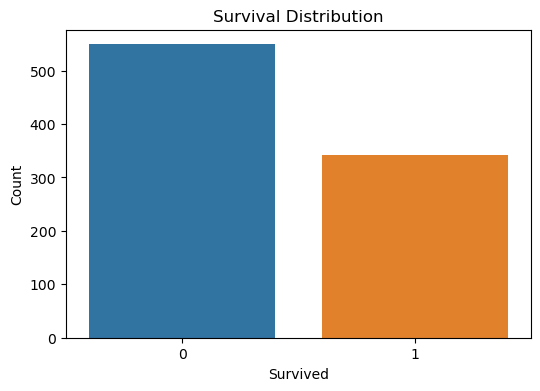

In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Survived', data=df)
plt.xlabel('Survived')
plt.ylabel('Count')
plt.title('Survival Distribution')
plt.show()

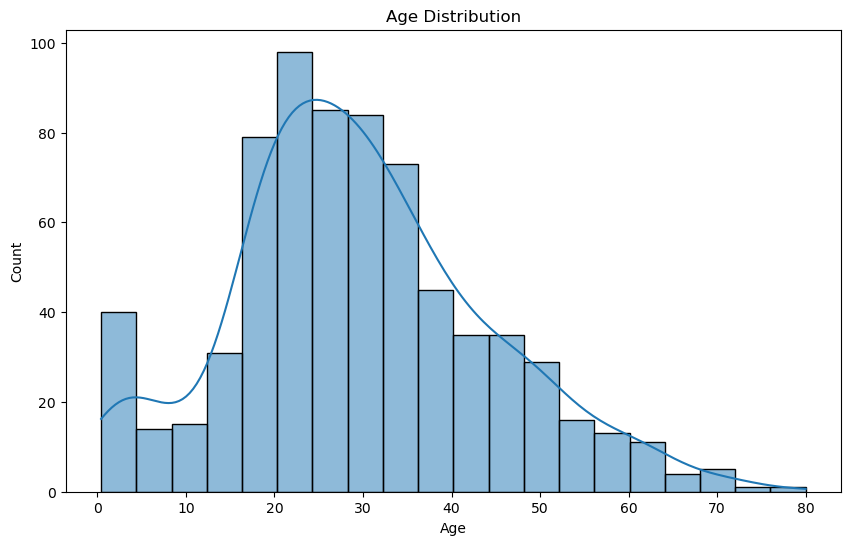

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], kde=True)
plt.xlabel('Age')
plt.title('Age Distribution')
plt.show();

/tmp/ipykernel_20/2573605431.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(y_percentages)


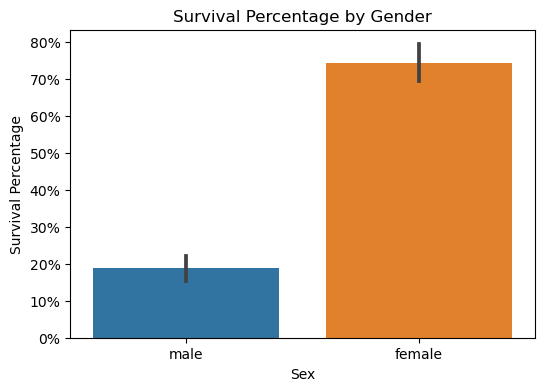

In [10]:
plt.figure(figsize=(6, 4))
sns.barplot(x='Sex', y='Survived', data=df)
plt.xlabel('Sex')
plt.ylabel('Survival Percentage')
plt.title('Survival Percentage by Gender')
y_vals = plt.gca().get_yticks()
y_percentages = [f'{val*100:.0f}%' for val in y_vals]
plt.gca().set_yticklabels(y_percentages)
plt.show();

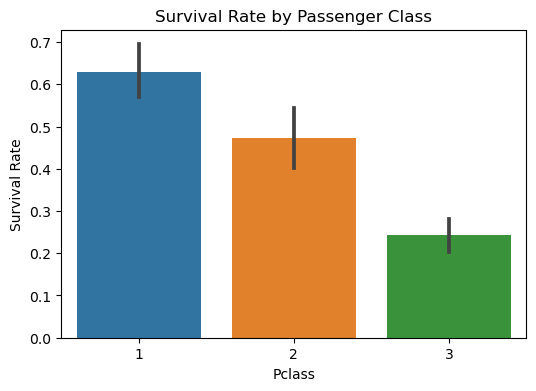

In [11]:
plt.figure(figsize=(6, 4))
sns.barplot(x='Pclass', y='Survived', data=df)
plt.xlabel('Pclass')
plt.ylabel('Survival Rate')
plt.title('Survival Rate by Passenger Class')
plt.show()

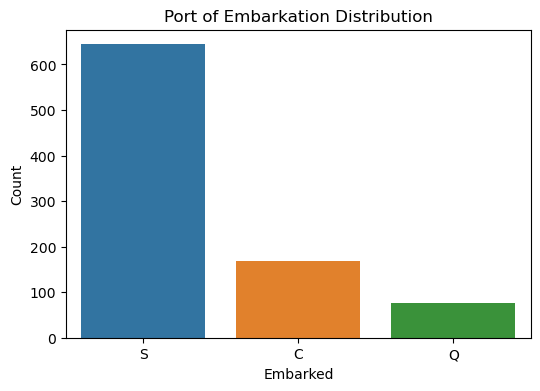

In [12]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Embarked', data=df)
plt.xlabel('Embarked')
plt.ylabel('Count')
plt.title('Port of Embarkation Distribution')
plt.show()

In [13]:
for column in df.columns:
    num_unique_values = df[column].nunique()
    print(column,"--->",num_unique_values)

Survived ---> 2
Pclass ---> 3
Sex ---> 2
Age ---> 88
SibSp ---> 7
Parch ---> 7
Fare ---> 248
Embarked ---> 3


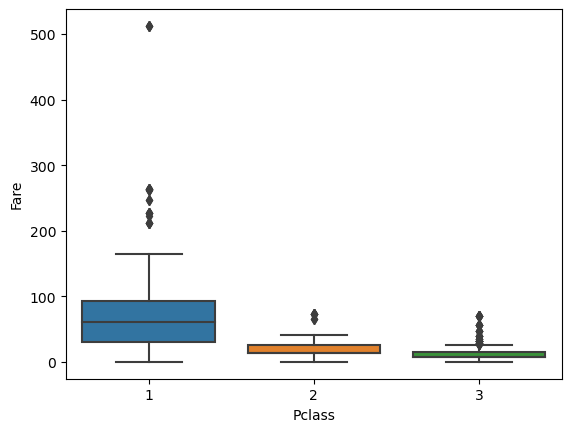

In [14]:
sns.boxplot(x="Pclass", y="Fare", data=df);

/tmp/ipykernel_20/3559395123.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')


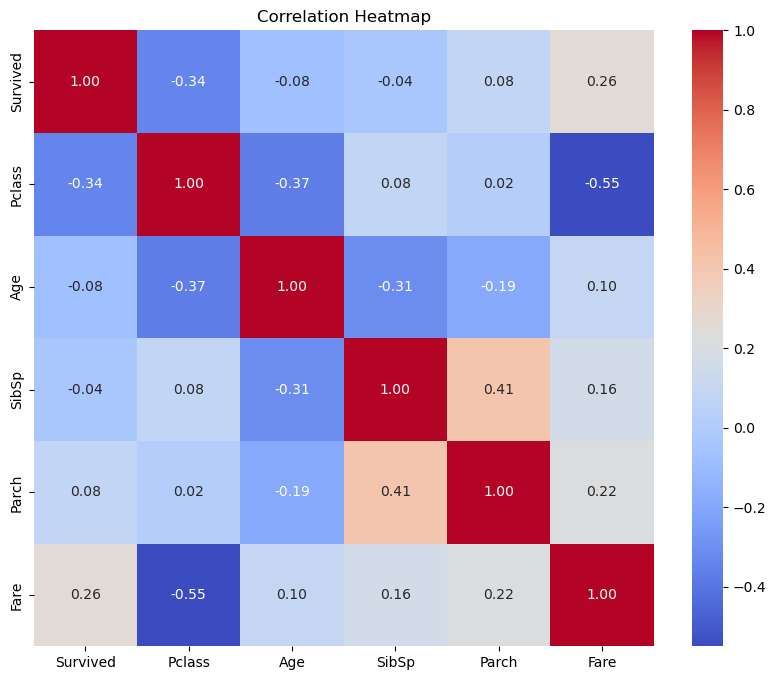

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show();

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


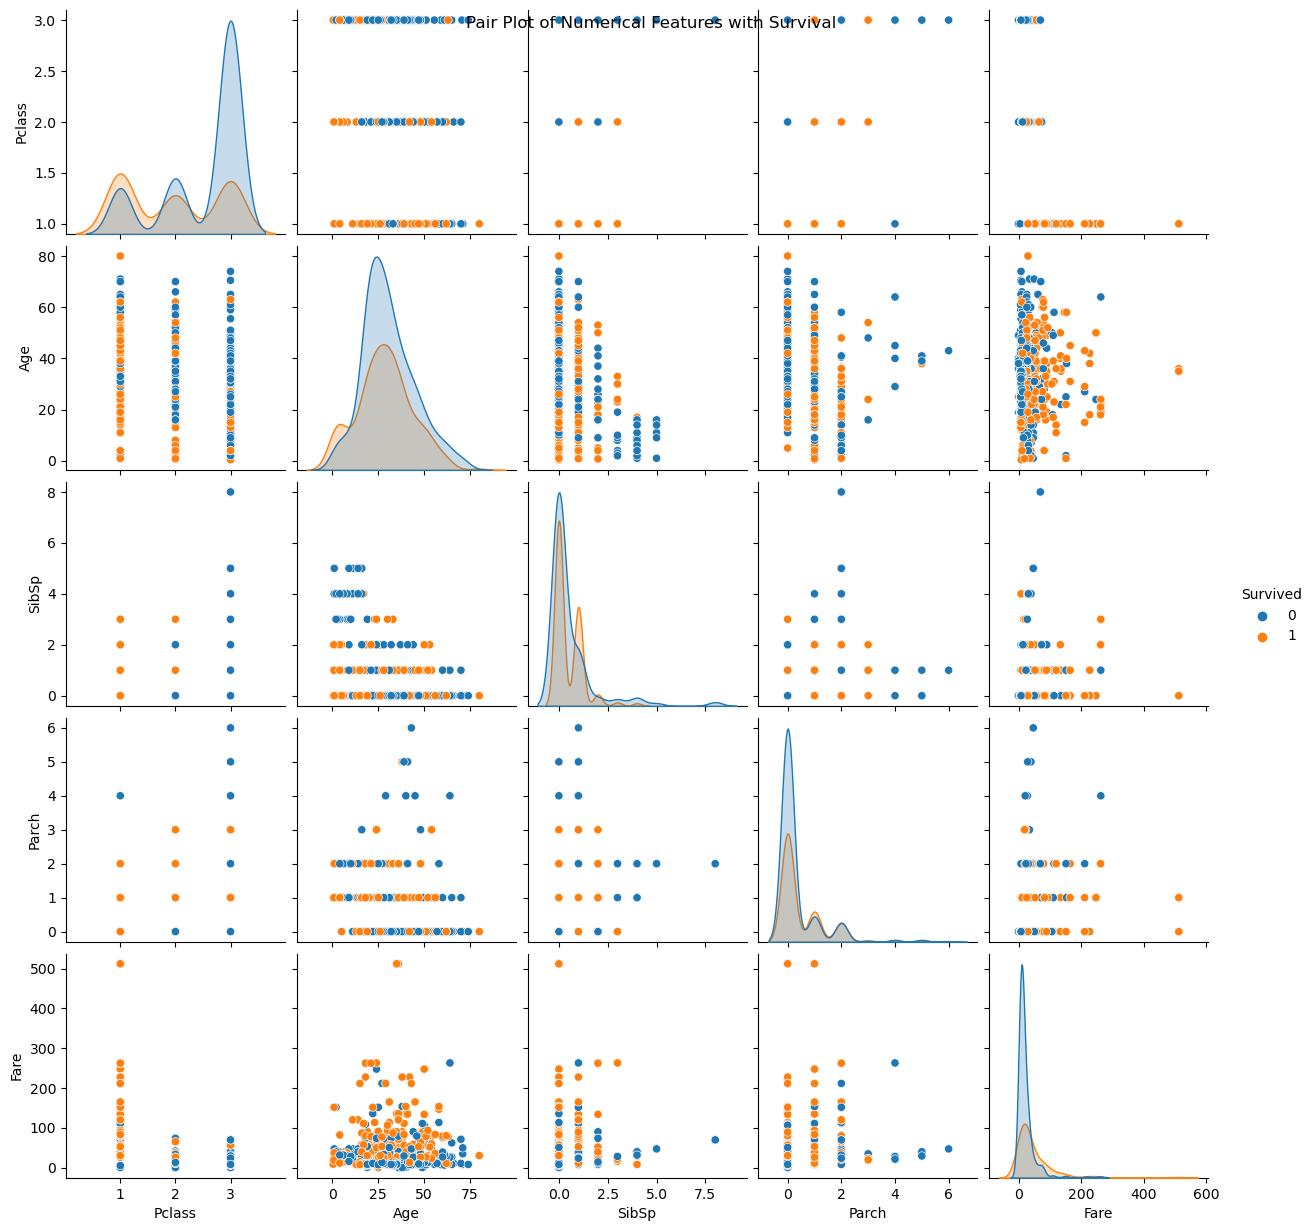

In [16]:
sns.pairplot(df, hue='Survived')
plt.suptitle('Pair Plot of Numerical Features with Survival')
plt.show()

In [17]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

## Split


In [18]:
target = "Survived"
X = df.drop(columns=target)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (801, 7)
y_train shape: (801,)
X_test shape: (90, 7)
y_test shape: (90,)


## Resample

In [19]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)
print(X_train_over.shape)
X_train_over.head()

(990, 7)


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,9.0,0,2,20.5250,S
1,3,female,9.0,4,2,31.2750,S
2,1,male,61.0,0,0,32.3208,S
3,3,male,NaN,0,0,7.7292,Q
4,3,male,NaN,0,0,7.8958,S


# Build Model

## Baseline

In [20]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.618


## Iterate

In [21]:
model_over = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy="mean"),
    DecisionTreeClassifier(random_state=42)
)
model_over.fit(X_train_over, y_train_over)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Sex', 'Embarked'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

In [22]:
param_grid = {
    'decisiontreeclassifier__criterion': ['gini', 'entropy'],
    'decisiontreeclassifier__max_depth': [None, 5, 10, 20],  # Add more values if desired
    'decisiontreeclassifier__min_samples_split': [2, 5, 10],  # Add more values if desired
}


In [23]:
grid_search = GridSearchCV(model_over, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_over, y_train_over)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(cols=['Sex', 'Embarked'],
                                                      use_cat_names=True)),
                                       ('simpleimputer', SimpleImputer()),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy'],
                         'decisiontreeclassifier__max_depth': [None, 5, 10, 20],
                         'decisiontreeclassifier__min_samples_split': [2, 5,
                                                                       10]},
             scoring='accuracy')

In [24]:
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Parameters: {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 20, 'decisiontreeclassifier__min_samples_split': 2}
Best Accuracy: 0.8393939393939392


## Evaluate

In [25]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Set:", round(accuracy, 2))

Accuracy on Test Set: 0.79


In [26]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.74      0.81        54
           1       0.69      0.86      0.77        36

    accuracy                           0.79        90
   macro avg       0.79      0.80      0.79        90
weighted avg       0.81      0.79      0.79        90



In [27]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[40 14]
 [ 5 31]]


In [28]:
depth = model_over.named_steps["decisiontreeclassifier"].get_depth()
print(depth)

22


# Communicate

/opt/conda/lib/python3.10/site-packages/category_encoders/utils.py:362: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


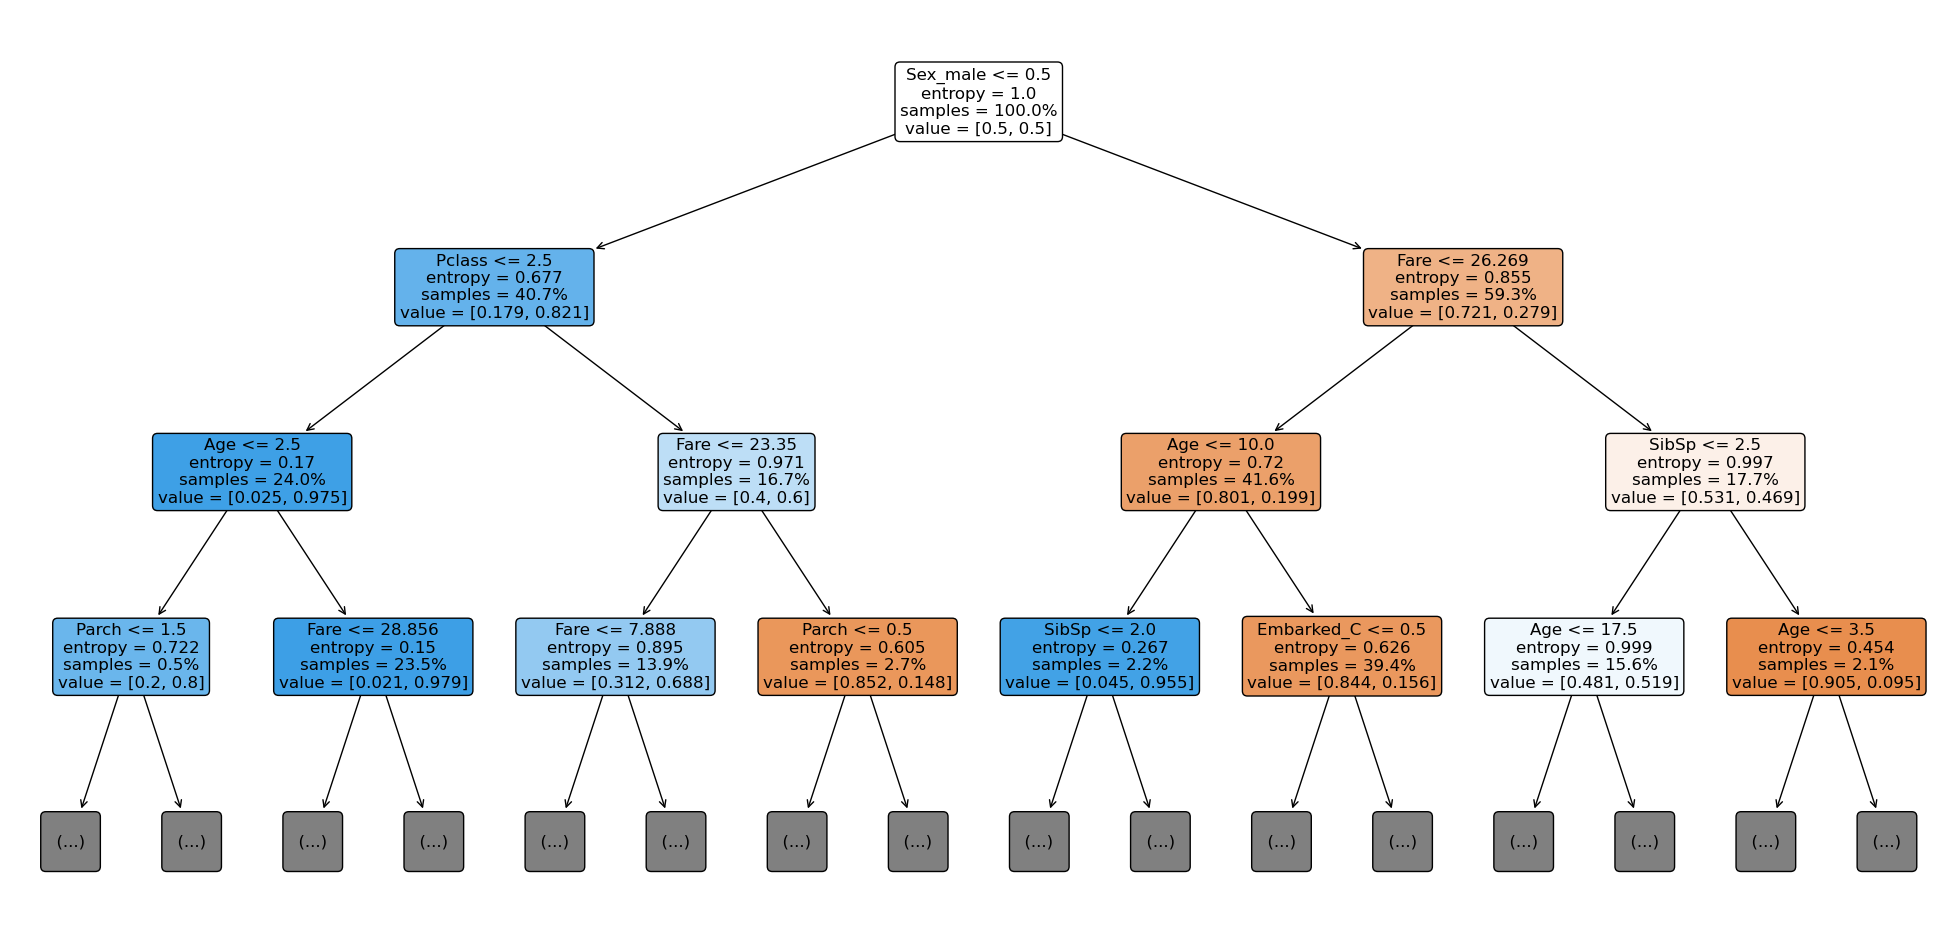

In [29]:
# Create larger figure
fig, ax = plt.subplots(figsize=(25, 12))
# Plot tree
plot_tree(
    decision_tree=best_model.named_steps["decisiontreeclassifier"],
    feature_names= model_over.named_steps["onehotencoder"].get_feature_names(),
    filled=True,  # Color leaf with class
    rounded=True,  # Round leaf edges
    proportion=True,  # Display proportion of classes in leaf
    max_depth=3,  # Only display first 3 levels
    fontsize=12,  # Enlarge font
    ax=ax,  # Place in figure axis
);

# Submission

In [30]:
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [31]:
X_test2 = test_df.drop(["Ticket", "Cabin", "PassengerId", "Name"], axis=1)

In [32]:
test_predictions = best_model.predict(X_test2)

In [33]:
submission = pd.DataFrame({"PassengerId": test_df["PassengerId"], "Survived": test_predictions})
submission.to_csv("submission.csv", index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
